# Telco Customer churn

This notebook is based on StatQuest with Josh Starmer webinar called XGBoost in [Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE). Here you will find exploratory data analysis and its conclusions and both dummy and XGBoost models to predict churn from a fictional company Telco.

[Here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) you can find the Telco customer churn data set on Kaggle.

All the code was written in Python 3, using Jupyter Notebooks.

In [1]:
# Importing libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

from utils.plotting import plot_confusion_matrix

In [2]:
pd.set_option("display.max_columns", None)

# EDA

In [3]:
# Uploading the dataset

df = pd.read_excel("c:\\telco_customer_churn.xlsx")

In [4]:
# Checking the first rows

df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


According to the documentation, the last three columns (Churn Score, CLTV, Churn Reason) were collected after the churn. Although they are excellent predictors, we will not use them in future models, so let's drop them. Also, there are redundant columns called "Lat Long" and "Churn Label" which held the same pieces of information from the Latitude and Longitude columns and Churn Value respectively. Thus we will drop them as well. 

In [5]:
# Dropping the post-churn columns

df.drop(["Churn Score", "CLTV", "Churn Reason", "Lat Long", "Churn Label"], axis=1, inplace=True)

Let's look at the main df characteristics to understand the dataset better.

In [6]:
# Displaying df's shape

df.shape

(7043, 28)

There 11 missing values for "Total Charges" column. Let's take a look at these records.

In [7]:
# Displaying data types

df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
dtype: object

"Total charges" was labeled as an object but this feature held numerical information. Let's change it to float64 type.

In [8]:
# Changing Total Charges column from string to float

df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

In [9]:
# Displaying the number of null values

df.isna().sum()

CustomerID            0
Count                 0
Country               0
State                 0
City                  0
Zip Code              0
Latitude              0
Longitude             0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
dtype: int64

Since we set the invalid parsing as NaN, the data set has 11 missing values. Let's look at them.

In [10]:
# Finding records for missing values

df[df["Total Charges"].isna()]

,CustomerID,Count,Country,State,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
2438,3115-CZMZD,1,United States,California,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
2667,4367-NUYAO,1,United States,California,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
4687,3213-VVOLG,1,United States,California,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5719,2923-ARZLG,1,United States,California,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6772,4075-WKNIU,1,United States,California,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


All the missing values from "Total Charges" is followed with zero tenure months. Therefore, all those clients did not have time to be charged yet. So it is necessary to fill them with 0.

In [11]:
# Filling the NaN records with 0

df["Total Charges"] = df["Total Charges"].fillna(0)

In [12]:
# Printing the customers locations

print("Country: ", df["Country"].unique()[0]) 
print("State: ", df["State"].unique()[0])

Country:  United States
State:  California


All the customers are from California, USA.

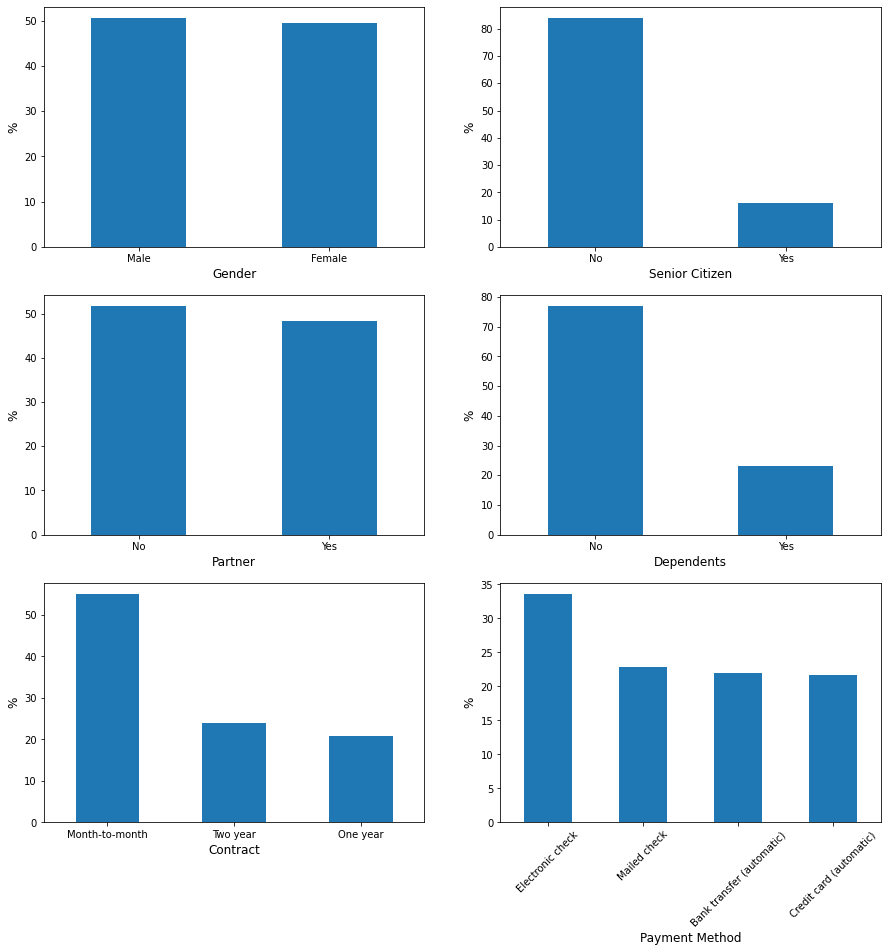

In [13]:
# Plotting the main categorical variables

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (15,15))

(df["Gender"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax1)
ax1.set_xlabel("Gender", fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("%", fontsize=12)

(df["Senior Citizen"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax2)
ax2.set_xlabel("Senior Citizen", fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel("%", fontsize=12)

(df["Partner"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax3)
ax3.set_xlabel("Partner", fontsize=12)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.set_ylabel("%", fontsize=12)

(df["Dependents"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax4)
ax4.set_xlabel("Dependents", fontsize=12)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.set_ylabel("%", fontsize=12)

(df["Contract"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax5)
ax5.set_xlabel("Contract", fontsize=12)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0)
ax5.set_ylabel("%", fontsize=12)

(df["Payment Method"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax6)
ax6.set_xlabel("Payment Method", fontsize=12)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
ax6.set_ylabel("%", fontsize=12)

plt.show()

We can see that:
- gender and partner are evenly distributed;
- around 80% of the customers have dependents and are not senior citizens (age above 65);
- most people have month-to-month contracts;
- and the payment method are almost evenly distributed as well.

Let's see the numerical features.

In [14]:
# Creating tenure years based on tenure months

df["Tenure Years"] = df["Tenure Months"]/12

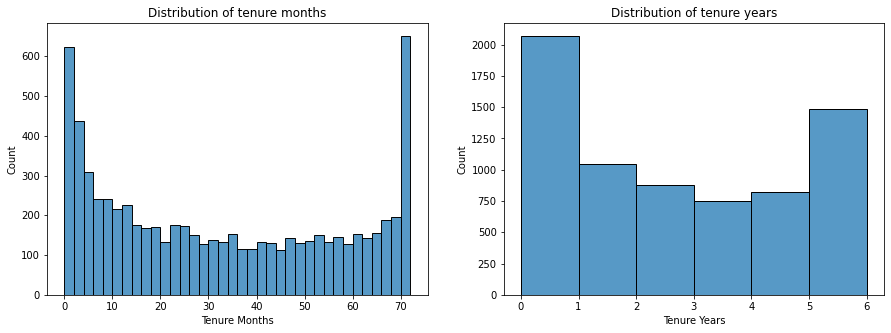

In [15]:
# Plotting the customer's tenure months

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.histplot(df, x="Tenure Months", bins=36, ax=ax1)
ax1.set_title("Distribution of tenure months")

sns.histplot(df, x="Tenure Years", bins=6, ax=ax2)
ax2.set_title("Distribution of tenure years")

plt.show()

Telco has a high number of new and old customers, i.e., clients with tenure below 1 year and above 5 years, respectively. With more detail, most of the old customers has exactly 72 months (6 years) which could indicate that Telco: 
- truncated tenure values above 6 years;
- had high number of customer acquisition for some reason 6 years ago.

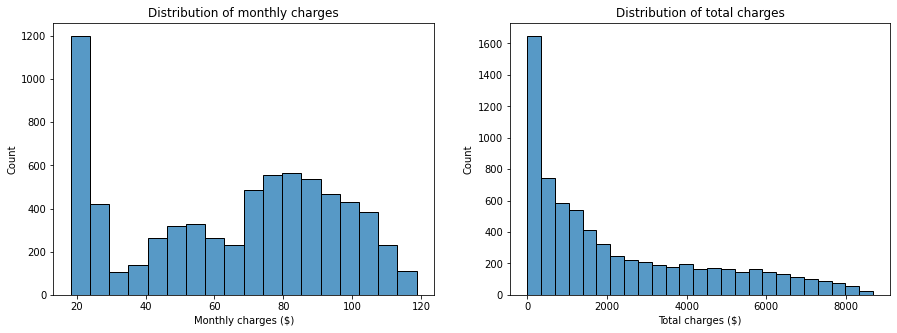

In [16]:
# Plotting the charges (total and monthly)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.histplot(df, x="Monthly Charges", ax=ax1)
ax1.set_title("Distribution of monthly charges")
ax1.set_xlabel("Monthly charges ($)")

sns.histplot(df, x="Total Charges", ax=ax2)
ax2.set_title("Distribution of total charges")
ax2.set_xlabel("Total charges ($)")

plt.show()

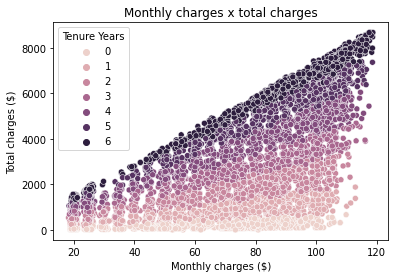

In [17]:
# Truncating the tenure years column

df["Tenure Years"] = (df["Tenure Months"]/12).round(0)

# Plotting the relationship between monthly and total charges

ax = sns.scatterplot(data=df, x="Monthly Charges", y="Total Charges", hue="Tenure Years")
ax.set_xlabel("Monthly charges ($)")
ax.set_ylabel("Total charges ($)")
ax.set_title("Monthly charges x total charges")
plt.show()

Looking at these graphs we can draw some insights:

1. The histograms show that the total charges have a high peak near 0 since Telco has a high number of new clients and low monthly charges. And these low monthly charges indicate that a lot of customers have basic plans.

2. The scatter plot above shows that the higher the monthly charges and the tenure years, the higher the total charges since it is the total charges over the years by each client calculated quarterly, which you should know only by reading the data set documentation. 

Lastly, let's see the distribution of the target column.

Text(0, 0.5, '%')

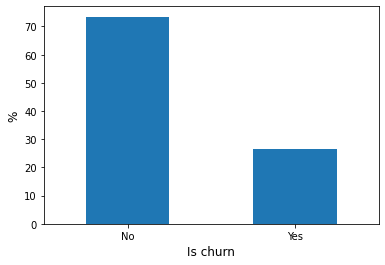

In [18]:
ax = (df["Churn Value"].value_counts(normalize=True)*100).plot(kind="bar")
ax.set_xlabel("Is churn", fontsize=12)
ax.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax.set_ylabel("%", fontsize=12)

Telco has a churn percentage of 30%. The ideal number is, of course, 0. The closer to that number, the better, and the company needs to know what makes customers cancel their contracts.

Here we can drop some other columns based on the analysis we just made. Count, Country, and State have only one unique value and CustomerID is only the identifier, and each row has one distinct value. Those features will not contribute to the model. Therefore we will drop them. 

In [19]:
# Dropping useless columns

df.drop(["CustomerID", "Country", "State", "Count"], axis=1, inplace=True)

Also, the data set may have whitespaces which could be hazardous to the model. The best way to solve this is to replace it with an underscore ("_") character.

In [20]:
# Replacing the whitespaces

df.replace(" ", "_", regex=True, inplace=True)

And it is necessary to do the same process with the column names.

In [21]:
# Replacing the whitespaces

df.columns = df.columns.str.replace(" ", "_")

Now, let's recall all the findings so far:

- gender, partner, and payment methods are evenly distributed;
- around 80% of the customers have dependents and are not senior citizens (age above 65);
- most people have month-to-month contracts;
- Telco has a high number of new and old customers, i.e., clients with tenure below 1 year and above 5 years, respectively;
- the higher the monthly charges and the tenure years, the higher the total charges;
- the company has a churn percentage of 30%.

---

# Feature formating

The data set has several categorical columns which almost every machine learning model can not handle. The solution is to convert them into boolean features using one-hot encoding. This type of encoding creates new columns based on different labels in the encoded feature. For example, if a column has only "Yes" and "No" as unique values, the algorithm will create two new columns with 0's and 1's.

In this data set, most of the categorical data have only 2 or 4 unique values but "City" has a lot. Then the algorithm will create one new column for every different record.

Let's perform one-hot encoding for the categorical features.

In [22]:
# List of all categorical features

cat_feat = ["City",
            "Gender",
            "Senior_Citizen",
            "Partner",
            "Dependents",
            "Phone_Service",
            "Multiple_Lines",
            "Internet_Service",
            "Online_Security",
            "Device_Protection",
            "Online_Backup",
            "Tech_Support",
            "Streaming_TV",
            "Streaming_Movies",
            "Contract",
            "Paperless_Billing",
            "Payment_Method"]

In [23]:
# Encoding categorical variables

df_encoded = pd.get_dummies(df, columns=cat_feat)

In [24]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
Tenure_Years         float64
dtype: object

In [25]:
# Dropping all categorical variables

df_encoded = df_encoded.select_dtypes(exclude=["object_"])
df_encoded.drop("Tenure_Years", axis=1, inplace=True)

From now on, we can split the data set into train and test sets and build the model.

---

# Models

First, let's split the data into X and y.

In [26]:
# Selecting the independent features

X = df_encoded.drop(["Churn_Value"], axis=1)
y = df_encoded["Churn_Value"]

In [27]:
X.shape

(7043, 1178)

Since the data set has unbalanced data around a 70/30 ratio, we need to guarantee that both sets have the same target class proportion, setting the parameter **stratify** equal to "y".

In [28]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Dummy classifier

A dummy classifier will create a bad model based on the strategy chosen. In this case, it will be the "most_frequent", i.e., the model will always return the same output based on the most frequent target class. This model will be used as the lower threshold for comparison to future models.

In [29]:
# Building the dummy model

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [30]:
# Model prediction

y_pred_dummy = dummy_clf.predict(X_test)

In [31]:
# Computing model's score

print("AUC score for the dummy model:", roc_auc_score(y_test, y_pred_dummy))

AUC score for the dummy model: 0.5


As expected, the AUC score for the dummy model is 0.5. It will be our baseline for the next model. **Note:** we did not need to build this dummy model since we decided to use AUC as the main score. By definition, the AUC of 0.5 is already a threshold for a bad classifier. I did this model just for an example. If we chose other metrics to evaluate our predictions besides AUC, building dummy classifiers is recommended.

## XGBoost

XGBoost stands for Extreme Gradient Boost and it is based on gradient boost.


But how does XGBoost work for classification?
First, the algorithm sets the target records, makes an initial prediction for them, which, by default, is 0.5, and calculates the residuals. An XGBoost tree is built to fit the residuals and it calculates the similarity score given by:

Similarity = $\frac{(\sum_{i} Residuals_{i})^{2}}{\sum_{i} Previous\_probability_{i}-(1-Previous\_probability_{i}) * \lambda}$,

where previous probability is the individual previous probabilities for each record and $\lambda$ is the regularization parameter which reduces the model sensitivity to the individual observations and prevents overfitting. Why? Because each tree's node has its similarity score and the algorithm calculates the gain, i.e., how well the model clustered the similar residuals and it is given by:

gain = $\sum Similarity_{branch}-Similary_{father\_node}$, 

and doing gain - $\gamma$, where $\gamma$ is the minimum loss reduction required to make a further partition on a leaf node of the tree ([source](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)). It decides if that branch is pruned or not: 
- the branch is not pruned if gain-$\gamma$ is **positive**;
- the branch is pruned if gain-$\gamma$ is **negative** and the model does not allow that branch to exist.

Then, the algorithm calculates the output value for each leaf using

output = $\frac{\sum residuals}{no\_of\_residuals-\lambda}$,

and right after, computes the new predictions using

pred = previous prediction * $\eta$ * output, 

where $\eta$ is the learning rate, i.e., how much that tree contributes to the model learning. The higher this value is the more relevant that tree will be. It is common to set it as 0.3 because it is better to do baby steps toward the best predictions. 

Finally, the model calculates the new residuals based on the new predictions and the process starts over again until it has tiny residuals or the model reaches the maximum number of iterations.

Now, let me explain some model parameters:
- verbose prints the model running on the screen;
- early_stopping_rounds indicates the maximum number of iterations without improving the score;
- eval_metric is the metric used to evaluate the model;
- eval_set is the set to evaluate over.

In [32]:
# Building the model

clf_xgb = xgb.XGBClassifier(objective="binary:logistic", seed=42)
clf_xgb.fit(X_train, y_train, early_stopping_rounds=10, verbose=True, eval_metric="aucpr", eval_set=[(X_test, y_test)])

C:\Users\steph\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65051
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65593
[18]	validation_0-aucpr:0.65738
[19]	validation_0-aucpr:0.65829
[20]	validation_0-aucpr:0.65683
[21]	validation_0-aucpr:0.65707


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
# Model prediction

y_pred_xgb = clf_xgb.predict(X_test)

The best AUCPR score is 0.66527, which is far from 1. Let's look at the confusion matrix to have a better big picture.

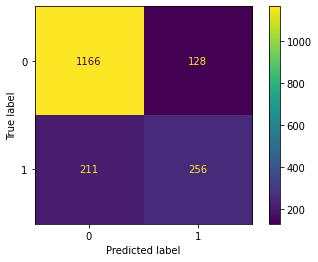

In [34]:
# Plotting the confusion matrix

plot_confusion_matrix(y_test, y_pred_xgb)

For the customers who did not leave the company, the model predicted $\frac{1166}{1166+128}$ = 90%. For those who left, the algorithm labeled $\frac{256}{256+211}$ = 54%. Every churn means Telco losing revenue. Therefore it is necessary to improve the number of true positives.

For this task, let's use the **scale_pos_weight** parameter which penalizes every incorrect minor target class prediction, in our case, the correct labeled customers who left the company. In addition, let's boost other hyperparameters, such as max_depth, learning_rate (default=0.3), gamma, reg_gamma, and, of course, scale_pos_weight using GridSearchCV. This function will run models with all the combinations set prior and select the best one.

Tuning all these parameters will take a while, so let's divide it into a few rounds. 

In [35]:
# Setting the params

params = {"max_depth": [3,4,5], "learning_rate": [0.1, 0.01, 0.05], "gamma": [0, 0,25, 1.0],
          "reg_gamma": [0, 1.0, 10.0], "scale_pos_weight": [3, 4, 5]}

Again, let's explain some cross-validation parameters:
- estimator is the model;
- param_grid is a list of the hyperparameter to tune;
- scoring is the scoring metric;
- verbose defines if the model prints each step of the process;
- n_jobs is the number of parallel jobs to run at each time;
- cv set the number of cross-validations.

In [36]:
# Building the CV

xgb_clf_tun = xgb.XGBClassifier(objective="binary:logistic", seed=42, subsample=0.9, colsample_bytree=0.5)
tuned_params = GridSearchCV(estimator=xgb_clf_tun, param_grid=params, scoring="roc_auc", verbose=0, n_jobs=10, cv=3) 

In [37]:
# Running the CV

tuned_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="aucpr", eval_set=[(X_test, y_test)])

C:\Users\steph\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg_gamma" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.57289
[1]	validation_0-aucpr:0.58002
[2]	validation_0-aucpr:0.61170
[3]	validation_0-aucpr:0.64063
[4]	validation_0-aucpr:0.64653
[5]	validation_0-aucpr:0.64544
[6]	validation_0-aucpr:0.64455
[7]	validation_0-aucpr:0.62761
[8]	validation_0-aucpr:0.63353
[9]	validation_0-aucpr:0.63583
[10]	validation_0-aucpr:0.63655
[11]	validation_0-aucpr:0.65303
[12]	validation_0-aucpr:0.65124
[13]	validation_0-aucpr:0.65120
[14]	validation_0-aucpr:0.65403
[15]	validation_0-aucpr:0.64770
[16]	validation_0-aucpr:0.64806
[17]	validation_0-aucpr:0.64781
[18]	validation_0-aucpr:0.64971
[19]	validati

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=0.9, tree_metho

In [38]:
# Printing the best parameters

print(tuned_params.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_gamma': 0, 'scale_pos_weight': 4}


Let's keep all the values because for **reg_gamma**, **learning_rate**, and **scale_pos_weight** because they are the lowest ones, and **max_depth** and **gamma** are the middle ones. Thus there is no need for other round of hyperparameters tuning.

Here are the best parameters for XGBoost: gamma = 1.0, learning_rate = 0.1, max_depth = 4, reg_gamma = 0, scale_pos_weight = 1.
Let's build the final model with all these numbers.

In [39]:
# Building the model

clf_xgb_boosted = xgb.XGBClassifier(objective="binary:logistic", seed=42, gamma = 1.0,
                            learning_rate = 0.1, max_depth = 4, reg_gamma = 0, scale_pos_weight = 4)
clf_xgb_boosted.fit(X_train, y_train, early_stopping_rounds=10, verbose=True, eval_metric="aucpr", eval_set=[(X_test, y_test)])

[19:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg_gamma" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.58949
[1]	validation_0-aucpr:0.59160
[2]	validation_0-aucpr:0.60804
[3]	validation_0-aucpr:0.61225
[4]	validation_0-aucpr:0.61405
[5]	validation_0-aucpr:0.61581
[6]	validation_0-aucpr:0.62737
[7]	validation_0-aucpr:0.64887
[8]	validation_0-aucpr:0.64997
[9]	validation_0-aucpr:0.64975
[10]	validation_0-aucpr:0.64980
[11]	validation_0-aucpr:0.65413
[12]	validation_0-aucpr:0.65357
[13]	validation_0-aucpr:0.65225
[14]	validation_0-aucpr:0.65505
[15]	validation_0-aucpr:0.65496
[16]	validation_0-aucpr:0.65413
[17]	validation_0-aucpr:0.65563
[18]	validation_0-aucpr:0.65077
[19]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_gamma=0, reg_lambda=1, scale_pos_weight=4,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

This time, the AUC score was 0.66517, which is slightly better than the non-boosted model. Let's look at the confusion matrix to see if the algorithm reaches the goal of improving the true positives.

In [40]:
# Model prediction

y_pred_xgb_boosted = clf_xgb_boosted.predict(X_test)

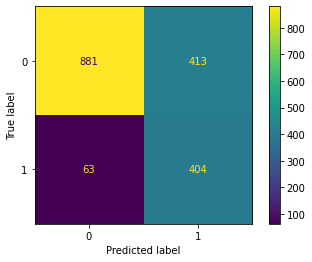

In [41]:
# Plotting the confusion matrix

plot_confusion_matrix(y_test, y_pred_xgb_boosted)

The hyperparameter boosting increased the number of true positives and predicted correctly $\frac{404}{404+63} = 87\%$ of those who had left the company (compared to 54% from the previous model). Otherwise, the number of false positives also increased and predicted correctly $\frac{881}{881+413} = 68\%$ (the without-boost model achieved 90%).

When there are churn, Telco loses money that will never come back, and a good way to deal with this problem is predict who is more likely to leave and draw action plans to retain them as much as possible.

---

# Action plans

To avoid churn, we can:
- give coupons/discounts for those 

In [42]:
X_test["Churn_Pred"] = y_pred_xgb_boosted

In [43]:
X_test

Zip_Code   Latitude   Longitude  Tenure_Months  Monthly_Charges  \
6215     94518  37.950248 -122.022455             52            80.20   
4582     92117  32.825086 -117.199424             33            24.25   
6444     95441  38.731771 -123.064272             10            53.70   
6213     94513  37.908242 -121.682472              1            85.00   
6605     95916  39.657228 -121.377780             52            50.20   
...        ...        ...         ...            ...              ...   
2226     92384  35.924252 -116.188668             35            76.05   
422      96092  39.955164 -122.018567             13            89.05   
6880     91326  34.281911 -118.556218             39           100.45   
773      95526  40.372532 -123.525626              3            31.00   
4780     93221  36.301689 -119.018233             29            45.90   

      Total_Charges  City_Acampo  City_Acton  City_Adelanto  City_Adin  \
6215        4297.60            0           0              0          0   
4582         838.50            0           0              0          0   
6444         521.00            0           0              0          0   
6213          85.00            0           0              0          0   
6605        2554.00            0           0              0          0   
...             ...          ...         ...            ...        ...   
2226        2747.20            0           0              0          0   
422         1169.35            0           0              0          0   
6880        3801.70            0           0              0          0   
773           95.05            0           0              0          0   
4780        1332.40            0           0              0          0   

      City_Agoura_Hills  City_Aguanga  City_Ahwahnee  City_Alameda  \
6215                  0             0              0             0   
4582                  0             0              0             0   
6444                  0             0              0             0   
6213                  0             0              0             0   
6605                  0             0              0             0   
...                 ...           ...            ...           ...   
2226                  0             0              0             0   
422                   0             0              0             0   
6880                  0             0              0             0   
773                   0             0              0             0   
4780                  0             0              0             0   

      City_Alamo  City_Albany  City_Albion  City_Alderpoint  City_Alhambra  \
6215           0            0            0                0              0   
4582           0            0            0                0              0   
6444           0            0            0                0              0   
6213           0            0            0                0              0   
6605           0            0            0                0              0   
...          ...          ...          ...              ...            ...   
2226           0            0            0                0              0   
422            0            0            0                0              0   
6880           0            0            0                0              0   
773            0            0            0                0              0   
4780           0            0            0                0              0   

      City_Aliso_Viejo  City_Alleghany  City_Alpaugh  City_Alpine  City_Alta  \
6215                 0               0             0            0          0   
4582                 0               0             0            0          0   
6444                 0               0             0            0          0   
6213                 0               0             0            0          0   
6605                 0               0             0          

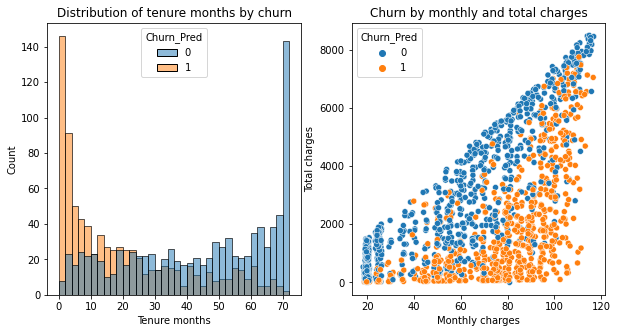

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

sns.histplot(X_test, x="Tenure_Months", hue="Churn_Pred", bins=36, ax=ax1)
ax1.set_title("Distribution of tenure months by churn")
ax1.set_xlabel("Tenure months")

sns.scatterplot(data=X_test, x="Monthly_Charges", y="Total_Charges", hue="Churn_Pred", ax=ax2)
ax2.set_title("Churn by monthly and total charges")
ax2.set_xlabel("Monthly charges")
ax2.set_ylabel("Total charges")

plt.show()

Based on the numerical features of the test size, most churn happens when the tenure months are low, i.e., new clients and their monthly charges are high. Now, it is possible to draw some action plans:
 
1. special offers for the first, two, or three months to retain new clients;
2. implement customized services and products for long-term customers;
3. deep dive into the reasons new clients (and all of them, of course) are churning.

---